<a href="https://colab.research.google.com/github/benjaminsw/MResDissertation/blob/main/LDA_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


clone data repo to colab space

ref: https://www.kdnuggets.com/2018/02/google-colab-free-gpu-tutorial-tensorflow-keras-pytorch.html/2

In [ ]:
!git clone https://github.com/benjaminsw/COVID-19.git

Cloning into 'COVID-19'...
remote: Enumerating objects: 1237, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 1237 (delta 27), reused 4 (delta 1), pack-reused 1156
Receiving objects: 100% (1237/1237), 400.89 MiB | 35.44 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Checking out files: 100% (1129/1129), done.


In [ ]:
# import library
from fastai.vision import *

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

re-name folder

In [ ]:
# list files in directory
!ls COVID-19

'DarkCovidNet  for binary classes.ipynb'       README.md
'DarkCovidNet model for three classes.ipynb'  'X-Ray Image DataSet'
 Kidney_stone_xresnet50_scratch.ipynb


In [ ]:
# rename folder to remove white space
!mv 'COVID-19/X-Ray Image DataSet' 'COVID-19/X-Ray_Image_DataSet'

In [ ]:
# list files in directory
!ls COVID-19/X-Ray_Image_DataSet

Covid-19  No_findings  Pneumonia


### prepare data set
ref: https://kapernikov.com/tutorial-image-classification-with-scikit-learn/

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

import joblib
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

In [ ]:
def resize_all(src, pklname, include, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1}) images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png', 'jpeg'}:
                    im = imread(os.path.join(current_path, file)) #, as_grey=True
                    im = rgb2gray(im)
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:-4])
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

In [ ]:
# set path
data_path = fr'/content/COVID-19/X-Ray_Image_DataSet'
os.listdir(data_path)

['No_findings', 'Pneumonia', 'Covid-19']

### set hight x width 

In [ ]:
base_name = 'X-Ray_Image_DataSet'
width = 128 #256 #80
include = {'Pneumonia', 'Covid-19', 'No_findings'}
 
resize_all(src=data_path, pklname=base_name, width=width, include=include)

No_findings
Pneumonia
Covid-19


In [ ]:
from collections import Counter
 
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  1061
keys:  ['description', 'label', 'filename', 'data']
description:  resized (128x128) images in rgb
image shape:  (128, 128)
labels: ['Covi' 'No_find' 'Pneum']


Counter({'Covi': 61, 'No_find': 500, 'Pneum': 500})

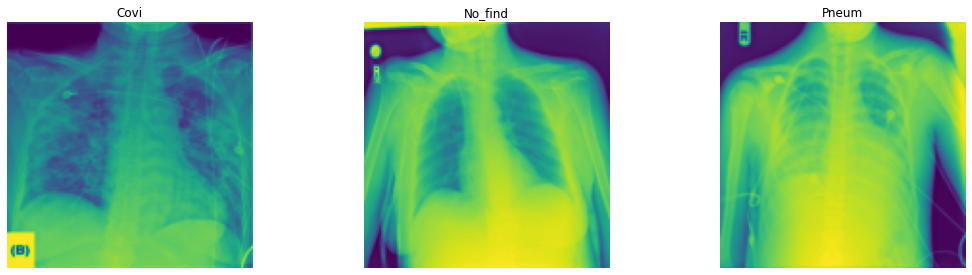

In [ ]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [ ]:
X = np.array(data['data'])
y = np.array(data['label'])

In [ ]:
# split train vs test
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=2021,
)

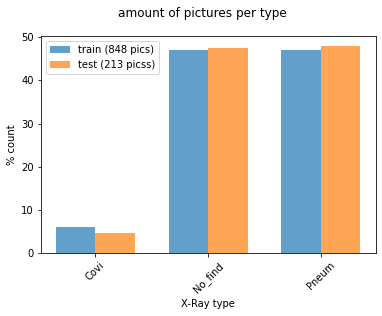

In [ ]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('X-Ray type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('amount of pictures per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} pics)'.format(len(y_train)), 
    'test ({0} picss)'.format(len(y_test))
]);

In [ ]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(1061, 128, 128)
(848, 128, 128)
(213, 128, 128)


In [ ]:
X_train.shape[0]

848

In [ ]:
# reshape tesnsor 
X_train_1d = np.reshape(X_train, (X_train.shape[0],-1)) 
X_test_1d = np.reshape(X_test, (X_test.shape[0],-1)) 
#X_train_1d

### fit LDA

ref: https://scikit-learn.org/stable/auto_examples/classification/plot_lda.html#sphx-glr-auto-examples-classification-plot-lda-py

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.covariance import OAS
import time

score_clf1, score_clf2, score_clf3 = 0, 0, 0

start_time = time.clock()
clf1 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X_train_1d, y_train)
print(time.clock() - start_time, "seconds")

In [ ]:
start_time = time.clock()
clf2 = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=None).fit(X_train_1d, y_train)
print(time.clock() - start_time, "seconds")

In [ ]:
# start_time = time.clock()
# oa = OAS(store_precision=False, assume_centered=False)
# clf3 = LinearDiscriminantAnalysis(solver='lsqr', covariance_estimator=oa).fit(X_1d, y)
# print(time.clock() - start_time, "seconds")

# compute score

In [ ]:
# compute the mean accuracy on the given test data and labels.
print('LDA with shrinkage (Ledoit Wolf): ', clf1.score(X_test_1d, y_test))
print('LDA: ', clf2.score(X_test_1d, y_test))
#print('LDA with OAS: ', clf3.score(X_1d, y))

LDA with shrinkage (Ledoit Wolf):  0.7183098591549296
LDA:  0.15023474178403756


# prediction

ref: https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

In [ ]:
# Predict class labels for samples in X.
# print(clf1.predict(X_test_1d))

In [ ]:
# Estimate log probability.
# print(clf1.predict_log_proba(X_test_1d))

In [ ]:
# Estimate probability.
# print(clf1.predict_proba(X_test_1d))